In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM, DistilBertConfig, DistilBertForMaskedLM
import torch.nn.functional as F
import copy
import os
import time
import math
import torch
from collections.abc import Mapping
import numpy as np
import matplotlib.pyplot as plt

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load Teacher Model and Tokenizer ---
teacher_model_name = 'bert-base-uncased'
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_model_name)
teacher_model = AutoModelForMaskedLM.from_pretrained(teacher_model_name)
teacher_model.eval()
teacher_model.to(device)
print(f"Teacher model ({teacher_model_name}) loaded and moved to {device}.")

2025-05-23 18:41:13.045750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748025673.233514      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748025673.292480      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Teacher model (bert-base-uncased) loaded and moved to cuda.


In [2]:
# --- Student Configuration ---
student_config = DistilBertConfig(
    vocab_size=teacher_tokenizer.vocab_size,
    n_layers=6,
    dim=teacher_model.config.hidden_size, # 768
    hidden_dim=teacher_model.config.intermediate_size, # 3072 (FFN)
    n_heads=teacher_model.config.num_attention_heads, # 12
    activation=teacher_model.config.hidden_act, # 'gelu'
    sinusoidal_pos_embds=False,
    dropout=0.1,
    attention_dropout=0.1,
    
)

student_model = DistilBertForMaskedLM(student_config)

teacher_state_dict = teacher_model.state_dict()
student_state_dict = student_model.state_dict()

# Word Embeddings
student_state_dict['distilbert.embeddings.word_embeddings.weight'] = teacher_state_dict['bert.embeddings.word_embeddings.weight'].clone()
# Positional Embeddings
student_state_dict['distilbert.embeddings.position_embeddings.weight'] = teacher_state_dict['bert.embeddings.position_embeddings.weight'].clone()
# LayerNorm for embeddings
student_state_dict['distilbert.embeddings.LayerNorm.weight'] = teacher_state_dict['bert.embeddings.LayerNorm.weight'].clone()
student_state_dict['distilbert.embeddings.LayerNorm.bias'] = teacher_state_dict['bert.embeddings.LayerNorm.bias'].clone()

teacher_layers_to_take = [0, 2, 4, 6, 8, 10]
for i_student_layer in range(student_config.n_layers):
    i_teacher_layer = teacher_layers_to_take[i_student_layer]
    
    # Attention
    student_state_dict[f'distilbert.transformer.layer.{i_student_layer}.attention.q_lin.weight'] = teacher_state_dict[f'bert.encoder.layer.{i_teacher_layer}.attention.self.query.weight'].clone()
    student_state_dict[f'distilbert.transformer.layer.{i_student_layer}.attention.q_lin.bias'] = teacher_state_dict[f'bert.encoder.layer.{i_teacher_layer}.attention.self.query.bias'].clone()
    student_state_dict[f'distilbert.transformer.layer.{i_student_layer}.attention.k_lin.weight'] = teacher_state_dict[f'bert.encoder.layer.{i_teacher_layer}.attention.self.key.weight'].clone()
    student_state_dict[f'distilbert.transformer.layer.{i_student_layer}.attention.k_lin.bias'] = teacher_state_dict[f'bert.encoder.layer.{i_teacher_layer}.attention.self.key.bias'].clone()
    student_state_dict[f'distilbert.transformer.layer.{i_student_layer}.attention.v_lin.weight'] = teacher_state_dict[f'bert.encoder.layer.{i_teacher_layer}.attention.self.value.weight'].clone()
    student_state_dict[f'distilbert.transformer.layer.{i_student_layer}.attention.v_lin.bias'] = teacher_state_dict[f'bert.encoder.layer.{i_teacher_layer}.attention.self.value.bias'].clone()
    student_state_dict[f'distilbert.transformer.layer.{i_student_layer}.attention.out_lin.weight'] = teacher_state_dict[f'bert.encoder.layer.{i_teacher_layer}.attention.output.dense.weight'].clone()
    student_state_dict[f'distilbert.transformer.layer.{i_student_layer}.attention.out_lin.bias'] = teacher_state_dict[f'bert.encoder.layer.{i_teacher_layer}.attention.output.dense.bias'].clone()
    student_state_dict[f'distilbert.transformer.layer.{i_student_layer}.sa_layer_norm.weight'] = teacher_state_dict[f'bert.encoder.layer.{i_teacher_layer}.attention.output.LayerNorm.weight'].clone()
    student_state_dict[f'distilbert.transformer.layer.{i_student_layer}.sa_layer_norm.bias'] = teacher_state_dict[f'bert.encoder.layer.{i_teacher_layer}.attention.output.LayerNorm.bias'].clone()
    
    # Feed Forward Network (FFN)
    student_state_dict[f'distilbert.transformer.layer.{i_student_layer}.ffn.lin1.weight'] = teacher_state_dict[f'bert.encoder.layer.{i_teacher_layer}.intermediate.dense.weight'].clone()
    student_state_dict[f'distilbert.transformer.layer.{i_student_layer}.ffn.lin1.bias'] = teacher_state_dict[f'bert.encoder.layer.{i_teacher_layer}.intermediate.dense.bias'].clone()
    student_state_dict[f'distilbert.transformer.layer.{i_student_layer}.ffn.lin2.weight'] = teacher_state_dict[f'bert.encoder.layer.{i_teacher_layer}.output.dense.weight'].clone()
    student_state_dict[f'distilbert.transformer.layer.{i_student_layer}.ffn.lin2.bias'] = teacher_state_dict[f'bert.encoder.layer.{i_teacher_layer}.output.dense.bias'].clone()
    student_state_dict[f'distilbert.transformer.layer.{i_student_layer}.output_layer_norm.weight'] = teacher_state_dict[f'bert.encoder.layer.{i_teacher_layer}.output.LayerNorm.weight'].clone()
    student_state_dict[f'distilbert.transformer.layer.{i_student_layer}.output_layer_norm.bias'] = teacher_state_dict[f'bert.encoder.layer.{i_teacher_layer}.output.LayerNorm.bias'].clone()

student_state_dict['vocab_transform.weight'] = teacher_state_dict['cls.predictions.transform.dense.weight'].clone()
student_state_dict['vocab_transform.bias'] = teacher_state_dict['cls.predictions.transform.dense.bias'].clone()
student_state_dict['vocab_layer_norm.weight'] = teacher_state_dict['cls.predictions.transform.LayerNorm.weight'].clone()
student_state_dict['vocab_layer_norm.bias'] = teacher_state_dict['cls.predictions.transform.LayerNorm.bias'].clone()

if 'cls.predictions.decoder.bias' in teacher_state_dict:
    student_state_dict['vocab_projector.bias'] = teacher_state_dict['cls.predictions.decoder.bias'].clone()

print(f"Student model (DistilBERT) created, weights initialized from teacher, and moved to {device}.")

Student model (DistilBERT) created, weights initialized from teacher, and moved to cuda.


In [4]:
# --- Loss Functions ---
def distillation_loss_soft_ce(student_logits, teacher_logits, temperature):
    """
    Soft Cross-Entropy (KL Divergence based)
    L_ce in the paper.
    """
    soft_teacher_probs = F.softmax(teacher_logits / temperature, dim=-1)
    soft_student_log_probs = F.log_softmax(student_logits / temperature, dim=-1)
    loss = F.kl_div(soft_student_log_probs, soft_teacher_probs.detach(), reduction='batchmean') * (temperature**2)
    return loss

def mlm_loss_fn(student_mlm_logits, true_labels_for_mlm):
    """
    Masked Language Modeling loss for the student.
    L_mlm in the paper.
    true_labels_for_mlm should have -100 for non-masked tokens.
    """
    loss = F.cross_entropy(
        student_mlm_logits.view(-1, student_mlm_logits.size(-1)),
        true_labels_for_mlm.view(-1),
        ignore_index=-100 
    )
    return loss

def cosine_similarity_loss_fn(student_hidden_states, teacher_hidden_states):
    """
    Cosine Embedding Loss between student and teacher hidden states.
    L_cos in the paper.
    The paper mentions sum_i (1 - cosine_similarity(s_hi, t_hi)) for corresponding layers.
    For simplicity, we can start by comparing the last hidden states.
    Let's assume student_hidden_states and teacher_hidden_states are the *last* hidden states:
    [batch_size, seq_len, hidden_dim]
    """
    student_pooled = student_hidden_states.mean(dim=1) 
    teacher_pooled = teacher_hidden_states.mean(dim=1) 

    loss = (1 - F.cosine_similarity(student_pooled, teacher_pooled.detach(), dim=-1)).mean()
    return loss


print("Loss functions defined.")

Loss functions defined.


In [5]:
from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling

# --- Configuration for Data Processing ---
block_size = 128

# --- Load WikiText-2 Dataset ---
raw_datasets = load_dataset("wikitext", "wikitext-2-raw-v1")


print(raw_datasets)

# --- Tokenization Function ---
def tokenize_function(examples):
    return teacher_tokenizer(examples["text"], truncation=False)

# --- Apply Tokenization ---
tokenized_datasets = raw_datasets.map(
    tokenize_function,
    batched=True,
    num_proc=2,
    remove_columns=["text"],
)
print(tokenized_datasets)

# --- Chunking into Fixed-Length Blocks ---
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size

    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }

    return result


lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    num_proc=2, # Use a couple of processors
)
print(lm_datasets)
print(f"Example of processed input_ids: {lm_datasets['train'][0]['input_ids'][:10]}")
print(f"Length of first training sample: {len(lm_datasets['train'][0]['input_ids'])}")


# --- Data Collator for Language Modeling ---

data_collator = DataCollatorForLanguageModeling(
    tokenizer=teacher_tokenizer,
    mlm=True,
    mlm_probability=0.15 # Standard MLM probability
)


train_dataset = lm_datasets["train"]
eval_dataset = lm_datasets["validation"]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


Map (num_proc=2):   0%|          | 0/4358 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


Map (num_proc=2):   0%|          | 0/36718 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (647 > 512). Running this sequence through the model will result in indexing errors


Map (num_proc=2):   0%|          | 0/3760 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3760
    })
})


Map (num_proc=2):   0%|          | 0/4358 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/36718 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/3760 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2201
    })
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 18554
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1922
    })
})
Example of processed input_ids: [101, 102, 101, 1027, 11748, 4801, 4360, 11906, 3523, 1027]
Length of first training sample: 128


In [6]:
# --- Evaluation function for MLM with optional metrics ---
def evaluate_model_mlm(model, eval_dataloader, device,
                       calculate_top1_accuracy=False,
                       calculate_inter_layer_cosine=False,
                       teacher_model_for_cosine=None):
    model.eval()
    total_eval_loss = 0
    all_preds = []
    all_labels = []
    all_student_hidden_states_for_cosine = []
    all_teacher_hidden_states_for_cosine = []

    with torch.no_grad():
        for batch in eval_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids,
                attention_mask=attention_mask,
                labels=labels,
                output_hidden_states=True
            )
            loss = outputs.loss
            total_eval_loss += loss.item()

            if calculate_top1_accuracy:
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=-1)
                masked_indices = (labels != -100)
                all_preds.append(predictions[masked_indices].cpu().numpy())
                all_labels.append(labels[masked_indices].cpu().numpy())

            if calculate_inter_layer_cosine and teacher_model_for_cosine:
                student_hidden_states_batch = tuple(hs.cpu() for hs in outputs.hidden_states)
                all_student_hidden_states_for_cosine.append(student_hidden_states_batch)

                teacher_outputs_cosine = teacher_model_for_cosine(
                    input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=True
                )
                teacher_hidden_states_batch = tuple(hs.cpu() for hs in teacher_outputs_cosine.hidden_states)
                all_teacher_hidden_states_for_cosine.append(teacher_hidden_states_batch)

    avg_eval_loss = total_eval_loss / len(eval_dataloader)
    perplexity = math.exp(avg_eval_loss)

    results = {
        "loss": avg_eval_loss,
        "perplexity": perplexity,
    }

    if calculate_top1_accuracy and len(all_labels) > 0:
        all_preds_np = np.concatenate(all_preds)
        all_labels_np = np.concatenate(all_labels)
        top1_accuracy = np.mean(all_preds_np == all_labels_np)
        results["top1_mlm_accuracy"] = top1_accuracy

    if calculate_inter_layer_cosine and teacher_model_for_cosine and len(all_student_hidden_states_for_cosine) > 0:
        avg_cosine_similarities = calculate_avg_inter_layer_cosine_similarity_batched(
            all_student_hidden_states_for_cosine,
            all_teacher_hidden_states_for_cosine
        )
        results["inter_layer_cosine_similarity"] = avg_cosine_similarities

    model.train()
    return results

# --- Cosine similarity calculation ---
def calculate_avg_inter_layer_cosine_similarity_batched(batched_student_hidden_states, batched_teacher_hidden_states):
    if not batched_student_hidden_states or not batched_teacher_hidden_states:
        return {}
    if len(batched_student_hidden_states[0]) == 0 or len(batched_teacher_hidden_states[0]) == 0:
        return {}

    num_student_total_layers = len(batched_student_hidden_states[0])
    num_student_transformer_layers = num_student_total_layers - 1

    layer_similarities_accum = {}
    num_batches = len(batched_student_hidden_states)

    for batch_idx in range(num_batches):
        student_hs_batch = batched_student_hidden_states[batch_idx]
        teacher_hs_batch = batched_teacher_hidden_states[batch_idx]

        s_emb = student_hs_batch[0][:, 0, :]
        t_emb = teacher_hs_batch[0][:, 0, :]
        sim_emb = F.cosine_similarity(s_emb, t_emb).mean().item()
        layer_similarities_accum["embeddings"] = layer_similarities_accum.get("embeddings", 0) + sim_emb

        for i in range(num_student_transformer_layers):
            student_layer_idx_in_tuple = 1 + i
            teacher_layer_idx_in_tuple = 1 + (i * 2)

            if teacher_layer_idx_in_tuple < len(teacher_hs_batch):
                s_hidden = student_hs_batch[student_layer_idx_in_tuple][:, 0, :]
                t_hidden = teacher_hs_batch[teacher_layer_idx_in_tuple][:, 0, :]
                sim_layer = F.cosine_similarity(s_hidden, t_hidden).mean().item()
                key = f"student_L{i}_vs_teacher_L{i*2}"
                layer_similarities_accum[key] = layer_similarities_accum.get(key, 0) + sim_layer

    avg_layer_similarities = {k: v / num_batches for k, v in layer_similarities_accum.items()}
    return avg_layer_similarities

# --- Plot training/validation losses and perplexities ---
def plot_loss_curves(train_losses_total, val_losses, val_perplexities, train_losses_components=None):
    epochs = range(1, len(train_losses_total) + 1)
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses_total, 'bo-', label='Training Loss (Total)')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss (MLM)')
    plt.title('Training and Validation MLM Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs, val_perplexities, 'go-', label='Validation Perplexity')
    plt.title('Validation Perplexity')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.grid(True)

    if train_losses_components:
        plt.subplot(1, 3, 3)
        for name, comp_loss in train_losses_components.items():
            if len(comp_loss) == len(epochs):
                plt.plot(epochs, comp_loss, 'o-', label=f'Train Loss ({name.upper()})')
        plt.title('Training Loss Components')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# --- Model size info ---
def get_model_size_info(model, model_name="model"):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"--- {model_name} Size ---")
    print(f"Number of trainable parameters: {num_params/1e6:.2f} M")
    print("-" * 30)


# --- Training step loss ablation snippet ---
def training_step(student_logits, teacher_logits, student_hidden_states, teacher_hidden_states,
                  labels, ablation_config,
                  alpha_ce, alpha_mlm, alpha_cos,
                  distillation_loss_soft_ce, mlm_loss_fn, cosine_similarity_loss_fn):
    loss_ce_val = distillation_loss_soft_ce(student_logits, teacher_logits)
    loss_mlm_val = mlm_loss_fn(student_logits, labels)
    loss_cos_val = cosine_similarity_loss_fn(student_hidden_states, teacher_hidden_states)

    if ablation_config == "full":
        loss = (alpha_ce * loss_ce_val) + (alpha_mlm * loss_mlm_val) + (alpha_cos * loss_cos_val)
    elif ablation_config == "mlm_only":
        loss = alpha_mlm * loss_mlm_val
        loss_ce_val = torch.tensor(0.0)
        loss_cos_val = torch.tensor(0.0)
    elif ablation_config == "mlm_ce":
        loss = (alpha_ce * loss_ce_val) + (alpha_mlm * loss_mlm_val)
        loss_cos_val = torch.tensor(0.0)
    elif ablation_config == "mlm_cos":
        loss = (alpha_mlm * loss_mlm_val) + (alpha_cos * loss_cos_val)
        loss_ce_val = torch.tensor(0.0)
    else:
        raise ValueError(f"Unknown ablation_config: {ablation_config}")

    return loss, loss_ce_val, loss_mlm_val, loss_cos_val

In [10]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
import math # For calculating perplexity

# --- Hyperparameters and Configuration ---
num_train_epochs = 7 # 
per_device_train_batch_size = 50
per_device_eval_batch_size = 50
learning_rate = 5e-5
weight_decay = 0.01
adam_beta1 = 0.9
adam_beta2 = 0.999
adam_epsilon = 1e-8
lr_scheduler_type = "linear" # or "cosine"
num_warmup_steps = 0 

# Distillation parameters
alpha_ce = 0.1   # reduce weight on distillation CE loss
alpha_mlm = 0.7  # increase weight on MLM loss
alpha_cos = 0.2  # keep cosine loss moderate
temperature = 4.0  # increase temperature to smooth teacher logits more

# --- DataLoader ---
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=data_collator,
    batch_size=per_device_train_batch_size
)
eval_dataloader = DataLoader(
    eval_dataset,
    collate_fn=data_collator,
    batch_size=per_device_eval_batch_size
)

# --- Optimizer ---
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in student_model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": weight_decay,
    },
    {
        "params": [p for n, p in student_model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=learning_rate,
    betas=(adam_beta1, adam_beta2),
    eps=adam_epsilon,
)

# --- Learning Rate Scheduler ---
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch
lr_scheduler = get_scheduler(
    name=lr_scheduler_type,
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)


In [11]:
print("--- Model Information ---")
get_model_size_info(teacher_model, "Teacher Model")
get_model_size_info(student_model, "Student Model (Initial)")

--- Model Information ---
--- Teacher Model Size ---
Number of trainable parameters: 109.51 M
------------------------------
--- Student Model (Initial) Size ---
Number of trainable parameters: 66.99 M
------------------------------


Starting training...
Epoch 1/7, Step 50/372, Avg Loss: 44.9265 (CE: 399.6618, MLM: 6.9787, Cos: 0.3761), LR: 4.90e-05
Epoch 1/7, Step 100/372, Avg Loss: 44.3235 (CE: 393.9803, MLM: 6.9330, Cos: 0.3617), LR: 4.81e-05
Epoch 1/7, Step 150/372, Avg Loss: 43.8480 (CE: 389.3051, MLM: 6.9240, Cos: 0.3534), LR: 4.71e-05
Epoch 1/7, Step 200/372, Avg Loss: 43.4407 (CE: 385.3468, MLM: 6.9091, Cos: 0.3481), LR: 4.61e-05
Epoch 1/7, Step 250/372, Avg Loss: 43.0600 (CE: 381.6563, MLM: 6.8938, Cos: 0.3434), LR: 4.52e-05
Epoch 1/7, Step 300/372, Avg Loss: 42.7788 (CE: 378.9632, MLM: 6.8780, Cos: 0.3394), LR: 4.42e-05
Epoch 1/7, Step 350/372, Avg Loss: 42.4829 (CE: 376.1282, MLM: 6.8615, Cos: 0.3352), LR: 4.33e-05

 Evaluating at end of Epoch 1...
Epoch 1 Validation Results: Loss=6.7058, Perplexity=817.11, Top-1 MLM Acc=0.11327852863313362
Inter-layer Cosine Similarities: {'embeddings': -0.028804426821760643, 'student_L0_vs_teacher_L0': -0.02512788638854638, 'student_L1_vs_teacher_L2': 0.019559042456631

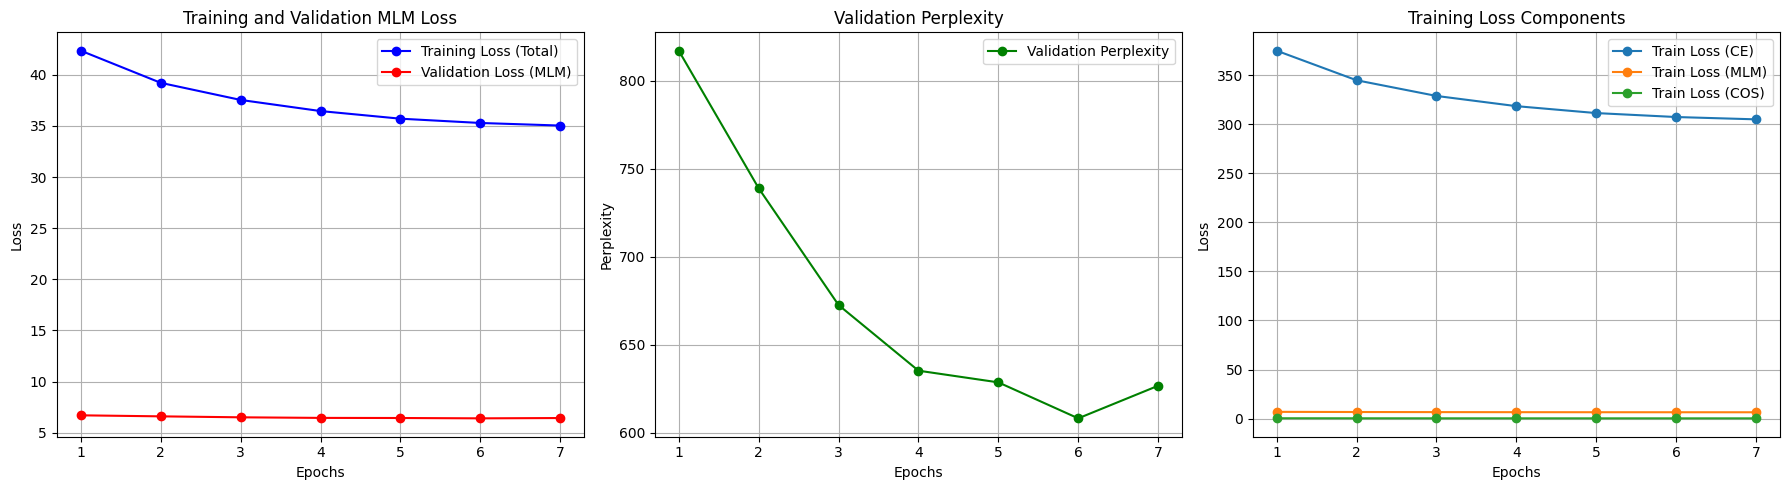

In [12]:
# --- Lists to store metrics for plotting ---
history = {
    "epoch_train_loss_total": [], "epoch_train_loss_ce": [], "epoch_train_loss_mlm": [], "epoch_train_loss_cos": [],
    "epoch_val_loss": [], "epoch_val_perplexity": [], "epoch_val_top1_mlm_accuracy": [],
    "epoch_val_inter_layer_cosine": [] # Store the dict of similarities
}

print("Starting training...")
student_model.train()
teacher_model.to(device)
student_model.to(device)

for epoch in range(num_train_epochs):
    total_loss_epoch = 0
    total_loss_ce_epoch = 0
    total_loss_mlm_epoch = 0
    total_loss_cos_epoch = 0
    student_model.train() # Make sure student is in train mode at the start of epoch

    for step, batch in enumerate(train_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Teacher pass (no gradients)
        with torch.no_grad():
            teacher_outputs = teacher_model(
                input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True
            )
        teacher_logits = teacher_outputs.logits.detach() # Detach immediately
        teacher_hidden_states_tuple = teacher_outputs.hidden_states
        teacher_last_hidden_state = teacher_hidden_states_tuple[-1].detach() # Detach immediately

        # Student pass
        student_outputs = student_model(
            input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        student_logits = student_outputs.logits
        student_hidden_states_tuple = student_outputs.hidden_states
        student_last_hidden_state = student_hidden_states_tuple[-1]

        # Calculate losses
        loss_ce = distillation_loss_soft_ce(student_logits, teacher_logits, temperature)
        loss_mlm = mlm_loss_fn(student_logits, labels)
        loss_cos = cosine_similarity_loss_fn(student_last_hidden_state, teacher_last_hidden_state)

        loss = (alpha_ce * loss_ce) + (alpha_mlm * loss_mlm) + (alpha_cos * loss_cos)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        # Accumulate step losses
        total_loss_epoch += loss.item()
        total_loss_ce_epoch += loss_ce.item()
        total_loss_mlm_epoch += loss_mlm.item()
        total_loss_cos_epoch += loss_cos.item()

        if step % 50 == 0 and step > 0: # Log progress
            current_avg_loss = total_loss_epoch / (step + 1)
            current_avg_ce = total_loss_ce_epoch / (step + 1)
            current_avg_mlm = total_loss_mlm_epoch / (step + 1)
            current_avg_cos = total_loss_cos_epoch / (step + 1)
            print(f"Epoch {epoch+1}/{num_train_epochs}, Step {step}/{len(train_dataloader)}, "
                  f"Avg Loss: {current_avg_loss:.4f} (CE: {current_avg_ce:.4f}, MLM: {current_avg_mlm:.4f}, Cos: {current_avg_cos:.4f}), "
                  f"LR: {lr_scheduler.get_last_lr()[0]:.2e}")

    # Calculate average losses for the epoch
    avg_epoch_loss_total = total_loss_epoch / len(train_dataloader)
    avg_epoch_loss_ce = total_loss_ce_epoch / len(train_dataloader)
    avg_epoch_loss_mlm = total_loss_mlm_epoch / len(train_dataloader)
    avg_epoch_loss_cos = total_loss_cos_epoch / len(train_dataloader)

    history["epoch_train_loss_total"].append(avg_epoch_loss_total)
    history["epoch_train_loss_ce"].append(avg_epoch_loss_ce)
    history["epoch_train_loss_mlm"].append(avg_epoch_loss_mlm)
    history["epoch_train_loss_cos"].append(avg_epoch_loss_cos)

    # --- Evaluation at the end of each epoch ---
    print(f"\n Evaluating at end of Epoch {epoch+1}...")
    # Ensure teacher_model is in eval mode if used by evaluate_model_mlm
    if teacher_model: # This refers to your globally/loop-scoped teacher_model variable
        teacher_model.eval() 

    epoch_eval_results = evaluate_model_mlm(
        student_model,
        eval_dataloader,
        device,
        calculate_top1_accuracy=True,
        calculate_inter_layer_cosine=True,
        teacher_model_for_cosine=teacher_model # Pass the teacher model for cosine calculation
    )

    history["epoch_val_loss"].append(epoch_eval_results["loss"])
    history["epoch_val_perplexity"].append(epoch_eval_results["perplexity"])
    if "top1_mlm_accuracy" in epoch_eval_results:
        history["epoch_val_top1_mlm_accuracy"].append(epoch_eval_results["top1_mlm_accuracy"])
    if "inter_layer_cosine_similarity" in epoch_eval_results:
        history["epoch_val_inter_layer_cosine"].append(epoch_eval_results["inter_layer_cosine_similarity"])

    print(f"Epoch {epoch+1} Validation Results: Loss={epoch_eval_results['loss']:.4f}, "
          f"Perplexity={epoch_eval_results['perplexity']:.2f}, "
          f"Top-1 MLM Acc={(epoch_eval_results.get('top1_mlm_accuracy', 'N/A'))}"
          )
    if "inter_layer_cosine_similarity" in epoch_eval_results:
        print(f"Inter-layer Cosine Similarities: {epoch_eval_results['inter_layer_cosine_similarity']}")
    print("-" * 30)


    # Save Model Checkpoint
    output_dir = f"./distilbert_wikitext2_epoch_{epoch+1}"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    student_model.save_pretrained(output_dir)
    teacher_tokenizer.save_pretrained(output_dir) # Save tokenizer for easy reloading
    print(f"Model saved to {output_dir}")

print("Training finished.")
print("="*50)

print("\n Starting Final Evaluation of the Student Model...")
student_model.to(device)
if teacher_model: # This refers to your globally/loop-scoped teacher_model variable
        teacher_model.eval()

final_eval_results = evaluate_model_mlm(
    student_model,
    eval_dataloader,
    device,
    calculate_top1_accuracy=True,
    calculate_inter_layer_cosine=True,
    teacher_model_for_cosine=teacher_model
)
print("\n--- Final Student Model Evaluation Results ---")
print(f"Loss: {final_eval_results['loss']:.4f}")
print(f"Perplexity: {final_eval_results['perplexity']:.2f}")
if "top1_mlm_accuracy" in final_eval_results:
    print(f"Top-1 MLM Accuracy: {final_eval_results['top1_mlm_accuracy']:.4f}")
if "inter_layer_cosine_similarity" in final_eval_results:
    print(f"Inter-layer Cosine Similarities: {final_eval_results['inter_layer_cosine_similarity']}")
print("="*50)

# --- Evaluation of the Teacher Model (as a baseline) ---
print("\n baseline Teacher Model Evaluation...")
if teacher_model: # Check if teacher_model is defined
    teacher_model.eval()
    teacher_eval_results = evaluate_model_mlm(
        teacher_model,
        eval_dataloader,
        device,
        calculate_top1_accuracy=True
        # No need for inter-layer cosine against itself or another teacher here
    )
    print("\n--- Teacher Model Baseline Evaluation Results ---")
    print(f"Loss: {teacher_eval_results['loss']:.4f}")
    print(f"Perplexity: {teacher_eval_results['perplexity']:.2f}")
    if "top1_mlm_accuracy" in teacher_eval_results:
        print(f"Top-1 MLM Accuracy: {teacher_eval_results['top1_mlm_accuracy']:.4f}")
else:
    print("Teacher model not available for baseline evaluation.")
print("="*50)


# --- Plotting Loss Curves ---
print("\n Plotting loss curves...")
plot_loss_curves(
    history["epoch_train_loss_total"],
    history["epoch_val_loss"],
    history["epoch_val_perplexity"],
    train_losses_components={
        'CE': history["epoch_train_loss_ce"],
        'MLM': history["epoch_train_loss_mlm"],
        'COS': history["epoch_train_loss_cos"]
    }
)
print("="*50)



In [13]:
def test_inference_latency(model, tokenizer, device, sample_texts, batch_size=8, num_runs=10, num_warmup_runs=3, max_length=128):
    import torch
    import time

    model.eval()
    all_tokenized_inputs = []
    for i in range(0, len(sample_texts), batch_size):
        batch = sample_texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
        # Remove token_type_ids if present
        inputs = {k: v for k, v in inputs.items() if k != "token_type_ids"}
        inputs = {k: v.to(device) for k, v in inputs.items()}
        all_tokenized_inputs.append(inputs)

    # Warmup
    with torch.no_grad():
        for _ in range(num_warmup_runs):
            for inputs_dict in all_tokenized_inputs:
                _ = model(**inputs_dict)

    # Timing
    total_samples_processed = 0
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            for inputs_dict in all_tokenized_inputs:
                _ = model(**inputs_dict)
                total_samples_processed += inputs_dict['input_ids'].size(0)
    end_time = time.time()

    avg_latency = (end_time - start_time) / (num_runs * len(all_tokenized_inputs))
    throughput = total_samples_processed / (end_time - start_time)
    print(f"Average Latency per batch: {avg_latency:.6f} seconds")
    print(f"Throughput: {throughput:.2f} samples/sec")
    return avg_latency

# --- Inference Latency Testing ---
print("\n Testing Inference Latency...")
sample_texts_for_latency = [
    "This is a sample sentence for latency testing.",
    "Another example to see how fast it processes text.",
    "DistilBERT aims to be a smaller and faster version of BERT.",
    "Knowledge distillation transfers knowledge from a teacher to a student.",
    "Evaluation metrics include perplexity and downstream task performance."
] * 20 # Make a reasonable number of samples

if student_model:
    print("\n--- Student Model Latency ---")
    student_latency_gpu = test_inference_latency(student_model.to(device), teacher_tokenizer, device, sample_texts_for_latency, batch_size=per_device_eval_batch_size)
if teacher_model:
    print("\n--- Teacher Model Latency ---")
    teacher_latency_gpu = test_inference_latency(teacher_model.to(device), teacher_tokenizer, device, sample_texts_for_latency, batch_size=per_device_eval_batch_size)
print("="*50)

print("All evaluation steps executed (conceptually).")


 Testing Inference Latency...

--- Student Model Latency ---
Average Latency per batch: 0.022781 seconds
Throughput: 2194.84 samples/sec

--- Teacher Model Latency ---
Average Latency per batch: 0.035145 seconds
Throughput: 1422.67 samples/sec
All evaluation steps executed (conceptually).
